In [1]:
pip install torch-kmeans

#Importing Libraries


In [2]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch_kmeans import KMeans
from tqdm.notebook import tqdm

#Loading Data and DataLoaders

In [3]:
batch_size_train = 100
batch_size_test = 100
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('fashionmnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('fashionmnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes=['T-shirt/top', ' Trouser', ' Pullover', ' Dress', ' Coat',
           ' Sandal', ' Shirt', 'Sneaker', ' Bag', 'Ankle boot']
examples = iter(train_loader)
samples, labels = next(examples)

print(samples.shape)
print(labels.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])


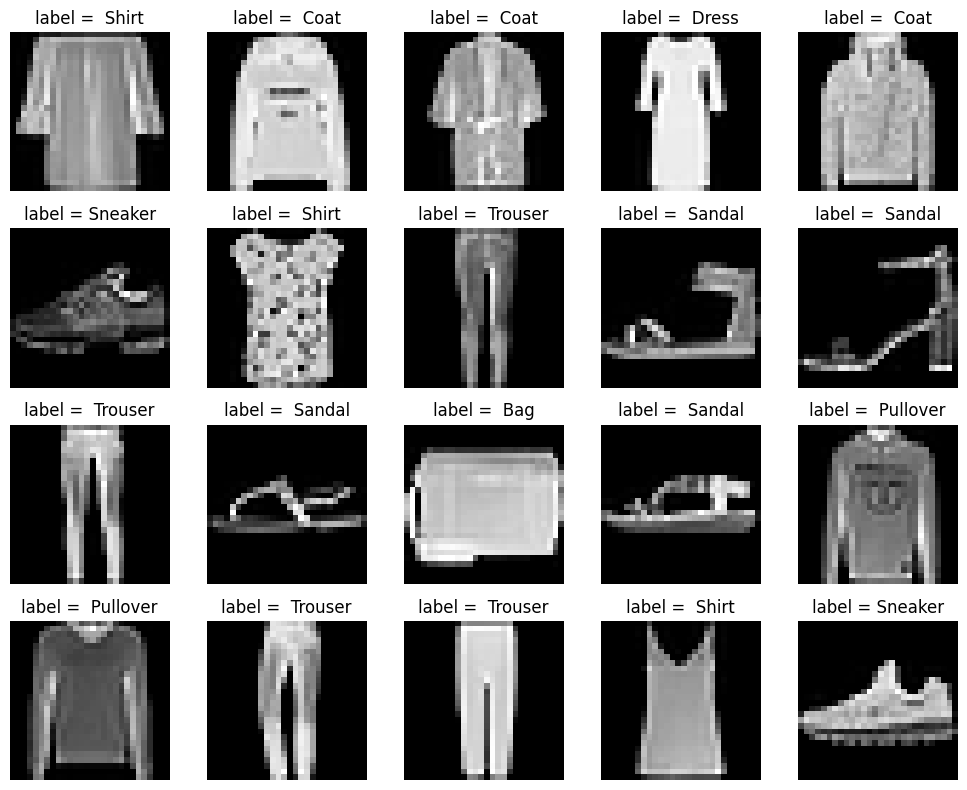

In [5]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig = plt.figure(figsize=(10, 8))

# Iterate over the first 6 samples
for i in range(20):
    # Add a subplot to the figure
    ax = fig.add_subplot(4, 5, i+1)

    # Display the image
    ax.imshow(samples[i][0], cmap="gray")

    ax.set_title(f"label = {classes[labels[i]]}")
    ax.axis("off")

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

#Model Definition

In [10]:
class mlp(nn.Module):
    def __init__(self,input_size,hl1,hl2,hl3,output_size,compression):
        super(mlp, self).__init__()
        self.InputLayer = nn.Linear(input_size,int((hl1*(100-compression))/100))
        self.HiddenLayer1 = nn.Linear(int((hl1*(100-compression))/100),int((hl2*(100-compression))/100))
        self.HiddenLayer2 = nn.Linear(int((hl2*(100-compression))/100),int((hl3*(100-compression))/100))
        self.OutputLayer = nn.Linear(int((hl3*(100-compression))/100), output_size)

    def forward(self, x):
        x = x.view((-1,784))
        x = F.relu(self.InputLayer(x))
        x = F.relu(self.HiddenLayer1(x))
        x = F.relu(self.HiddenLayer2(x))
        return self.OutputLayer(x)
weights = [128,64,16]
compression = 0
model = mlp(784,weights[0],weights[1],weights[2],10,compression).cuda()
for layer in model.children():
    print(layer)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=16, bias=True)
Linear(in_features=16, out_features=10, bias=True)


#Learning and Model Compression

In [11]:
def perform_update(m,j):
    if type(m) == nn.Linear:
        m.eval()
        x =m.weight.data
        if(m.weight.data.size(dim=0)!=10):
            num_clusters = int(((100-compression)*weights[j])/100)
            clustering_model = KMeans(n_clusters=num_clusters)
            result = clustering_model(torch.reshape(m.weight.data,(1,m.weight.data.size(dim=0),m.weight.data.size(dim=1))))
            x = torch.reshape(result.centers,(result.centers.size(dim=1),result.centers.size(dim=2)))
        if(x.size(dim=1)!=784):
            num_clusters = int(((100-compression)*weights[j-1])/100)
            clustering_model = KMeans(n_clusters=num_clusters)
            result = clustering_model(torch.reshape(x,(1,x.size(dim=1),x.size(dim=0))))
            x = torch.reshape(result.centers,(result.centers.size(dim=2),result.centers.size(dim=1)))

        return x

In [12]:
test_loss_min = np.Inf
LR=5e-4
optimizer = optim.Adam(model.parameters(), lr=LR)
test_acc_max = -100
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
historyCompression = {'compression': [], 'comp_acc': [],'deleted_weights': []}
TARGETACC=86
stableAcc = 0
compressionStart = False
models = []
for epoch in range(1, 100):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(model.parameters(), lr=LR)

    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    model.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min, test_loss))
        torch.save(model.state_dict(), 'MLP_leastLoss.pt')
        test_loss_min = test_loss
    if(TARGETACC<=test_acc):
      stableAcc +=1
    if(stableAcc>=5):
      compressionStart = True
    if(compressionStart):
      torch.save(model.state_dict(), 'MLPCompression'+str(compression)+'Percent.pt')
      historyCompression['compression'].append(compression)
      historyCompression['comp_acc'].append(test_acc)
      old = 784*int((weights[0]*(100-compression))/100)
      old += int((weights[0]*(100-compression))/100)*int((weights[1]*(100-compression))/100)
      old += int((weights[1]*(100-compression))/100) *int((weights[2]*(100-compression))/100)
      old +=int((weights[2]*(100-compression))/100) * 10
      compression += 10
      new_weights=[]
      index=0
      for layer in model.named_modules():
        new_weights.append(perform_update(layer,index))
        index+=1
      new = 784*int((weights[0]*(100-compression))/100)
      new += int((weights[0]*(100-compression))/100)*int((weights[1]*(100-compression))/100)
      new += int((weights[1]*(100-compression))/100) *int((weights[2]*(100-compression))/100)
      new +=int((weights[2]*(100-compression))/100) * 10
      deletedweights = old - new
      historyCompression['deleted_weights'].append(deletedweights)
      model = mlp(784,weights[0],weights[1],weights[2],10,compression).cuda()
      index=0
      for layer in model.named_modules():
        if type(layer) == nn.Linear:
          layer.weight.data = new_weights[index]
          index+=1
      optimizer = optim.Adam(model.parameters(), lr=LR)
      print("Deleted Weights",deletedweights)
      print("Compressed Model")
      for layer in model.children():
        print(layer)
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(test_acc)
    if(compression ==100):
      break

Epoch 1 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.612308 - Testing Loss: 0.460162 - Training Accuracy: 78.44% - Testing Accuracy: 83.10%
Testing loss decreased (inf --> 0.460162). The new model saved.
Epoch 2 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.396336 - Testing Loss: 0.411923 - Training Accuracy: 85.58% - Testing Accuracy: 85.18%
Testing loss decreased (0.460162 --> 0.411923). The new model saved.
Epoch 3 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.355653 - Testing Loss: 0.400602 - Training Accuracy: 86.98% - Testing Accuracy: 85.66%
Testing loss decreased (0.411923 --> 0.400602). The new model saved.
Epoch 4 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.330465 - Testing Loss: 0.367207 - Training Accuracy: 87.92% - Testing Accuracy: 86.89%
Testing loss decreased (0.400602 --> 0.367207). The new model saved.
Epoch 5 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.311483 - Testing Loss: 0.349416 - Training Accuracy: 88.61% - Testing Accuracy: 87.50%
Testing loss decreased (0.367207 --> 0.349416). The new model saved.
Epoch 6 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.293333 - Testing Loss: 0.366522 - Training Accuracy: 89.21% - Testing Accuracy: 86.73%
Epoch 7 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.282707 - Testing Loss: 0.340722 - Training Accuracy: 89.51% - Testing Accuracy: 87.91%
Testing loss decreased (0.349416 --> 0.340722). The new model saved.
Epoch 8 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.271208 - Testing Loss: 0.342042 - Training Accuracy: 89.92% - Testing Accuracy: 87.80%
Deleted Weights 12075
Compressed Model
Linear(in_features=784, out_features=115, bias=True)
Linear(in_features=115, out_features=57, bias=True)
Linear(in_features=57, out_features=14, bias=True)
Linear(in_features=14, out_features=10, bias=True)
Epoch 9 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.663901 - Testing Loss: 0.466489 - Training Accuracy: 76.89% - Testing Accuracy: 83.55%
Deleted Weights 11751
Compressed Model
Linear(in_features=784, out_features=102, bias=True)
Linear(in_features=102, out_features=51, bias=True)
Linear(in_features=51, out_features=12, bias=True)
Linear(in_features=12, out_features=10, bias=True)
Epoch 10 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.754007 - Testing Loss: 0.479151 - Training Accuracy: 73.31% - Testing Accuracy: 82.95%
Deleted Weights 11616
Compressed Model
Linear(in_features=784, out_features=89, bias=True)
Linear(in_features=89, out_features=44, bias=True)
Linear(in_features=44, out_features=11, bias=True)
Linear(in_features=11, out_features=10, bias=True)
Epoch 11 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.701504 - Testing Loss: 0.476225 - Training Accuracy: 76.77% - Testing Accuracy: 83.12%
Deleted Weights 11382
Compressed Model
Linear(in_features=784, out_features=76, bias=True)
Linear(in_features=76, out_features=38, bias=True)
Linear(in_features=38, out_features=9, bias=True)
Linear(in_features=9, out_features=10, bias=True)
Epoch 12 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.793237 - Testing Loss: 0.497151 - Training Accuracy: 73.22% - Testing Accuracy: 82.89%
Deleted Weights 10344
Compressed Model
Linear(in_features=784, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=8, bias=True)
Linear(in_features=8, out_features=10, bias=True)
Epoch 13 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.844156 - Testing Loss: 0.505305 - Training Accuracy: 72.21% - Testing Accuracy: 82.16%
Deleted Weights 11091
Compressed Model
Linear(in_features=784, out_features=51, bias=True)
Linear(in_features=51, out_features=25, bias=True)
Linear(in_features=25, out_features=6, bias=True)
Linear(in_features=6, out_features=10, bias=True)
Epoch 14 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 1.030851 - Testing Loss: 0.566148 - Training Accuracy: 62.38% - Testing Accuracy: 79.85%
Deleted Weights 10839
Compressed Model
Linear(in_features=784, out_features=38, bias=True)
Linear(in_features=38, out_features=19, bias=True)
Linear(in_features=19, out_features=4, bias=True)
Linear(in_features=4, out_features=10, bias=True)
Epoch 15 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 1.093226 - Testing Loss: 0.604926 - Training Accuracy: 60.22% - Testing Accuracy: 79.21%
Deleted Weights 10664
Compressed Model
Linear(in_features=784, out_features=25, bias=True)
Linear(in_features=25, out_features=12, bias=True)
Linear(in_features=12, out_features=3, bias=True)
Linear(in_features=3, out_features=10, bias=True)
Epoch 16 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 1.940689 - Testing Loss: 1.713578 - Training Accuracy: 23.16% - Testing Accuracy: 30.23%
Deleted Weights 10470
Compressed Model
Linear(in_features=784, out_features=12, bias=True)
Linear(in_features=12, out_features=6, bias=True)
Linear(in_features=6, out_features=1, bias=True)
Linear(in_features=1, out_features=10, bias=True)
Epoch 17 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 2.099739 - Testing Loss: 1.951569 - Training Accuracy: 18.53% - Testing Accuracy: 24.68%
Deleted Weights 9496
Compressed Model
Linear(in_features=784, out_features=0, bias=True)
Linear(in_features=0, out_features=0, bias=True)
Linear(in_features=0, out_features=0, bias=True)
Linear(in_features=0, out_features=10, bias=True)


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


#Result Visualization


[87.8, 83.55, 82.95, 83.12, 82.89, 82.16, 79.85, 79.21, 30.23, 24.68]
[12075, 11751, 11616, 11382, 10344, 11091, 10839, 10664, 10470, 9496]


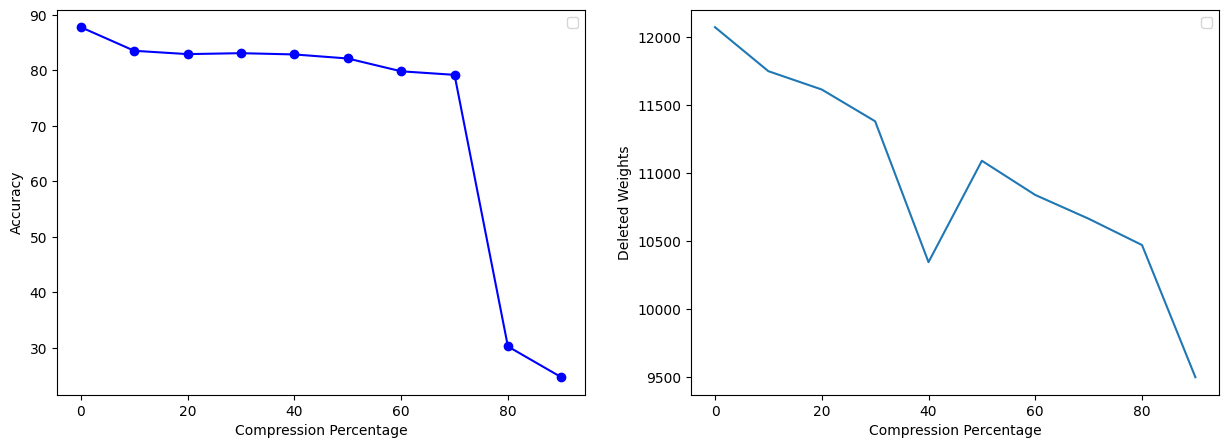

In [17]:
print(historyCompression['comp_acc'])
print(historyCompression['deleted_weights'])
fig=plt.figure(1,figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(historyCompression['compression'],historyCompression['comp_acc'], 'bo-')
plt.xlabel('Compression Percentage')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(historyCompression['compression'],historyCompression['deleted_weights'])
plt.xlabel('Compression Percentage')
plt.ylabel('Deleted Weights')
plt.legend()

In [14]:
S1 = historyCompression['comp_acc'][0]*90
S2=0
for i in range(len(historyCompression['compression'])-1):
  S2 +=((historyCompression['comp_acc'][i]+historyCompression['comp_acc'][i+1])*10)/2
print("مساحت هدف ",S1)
print("مساحت فشرده شده",S2)
print(" {:.2f}مساحت درصدری زیر نمودار  ".format((S2/S1)*100))

مساحت هدف  7902.0
مساحت فشرده شده 6602.0
 83.55مساحت درصدری زیر نمودار  
